# Chapter 03 word2vec

이번 장의 목표 : '단순한' word2vec 구현하기

## 3.1 추론 기반 기법과 신경망

### 3.1.1 통계 기반 기법의 문제점

통계 기반 기법 : 주변 단어의 빈도를 기초로 단어를 표현. 단어의 동시발생 행렬을 만들고 그 행렬에 SVD를 적용하여 밀집벡터(단어의 분산표현) 생성.

그러나 통계 기반 기법 방식은 대규모 말뭉치를 다룰 때 문제가 발생.

영어의 어휘 수는 100만을 훌쩍 넘는데, 이 경우 통계 기반 기법에서는 '100만 $\times$ 100만'이라는 거대한 행렬을 만들게 됨.

이런 거대 행렬에 SVD를 적용하는 건 현실적이지 않음

$\textbf{NOTE}$

SVD를 $n \times n$ 행렬에 적용하는 비용은 $O(n^{3})$. 매우 큰 비용으로, 근사적인 기법과 희소행렬의 성질 등을 이용해서 속도 개선이 가능하나 여전히 많은 양의 컴퓨팅 자원이 필요함.

통계 기반 기법은 말뭉치 전체의 통계(동시발생 행렬과 PPMI 등)를 이용해 단 1회의 처리(SVD 등)만에 단어의 분산 표현을 얻는다.

한편, 추론 기반 기법에서는, 특히 신경망을 이용하는 경우는 미니배치로 학습하는 것이 일반적임.

미니배치 학습에서는 신경망이 한 번에 소량(미니배치)의 학습 샘플씩 반복해서 학습하며 가중치를 갱신함.

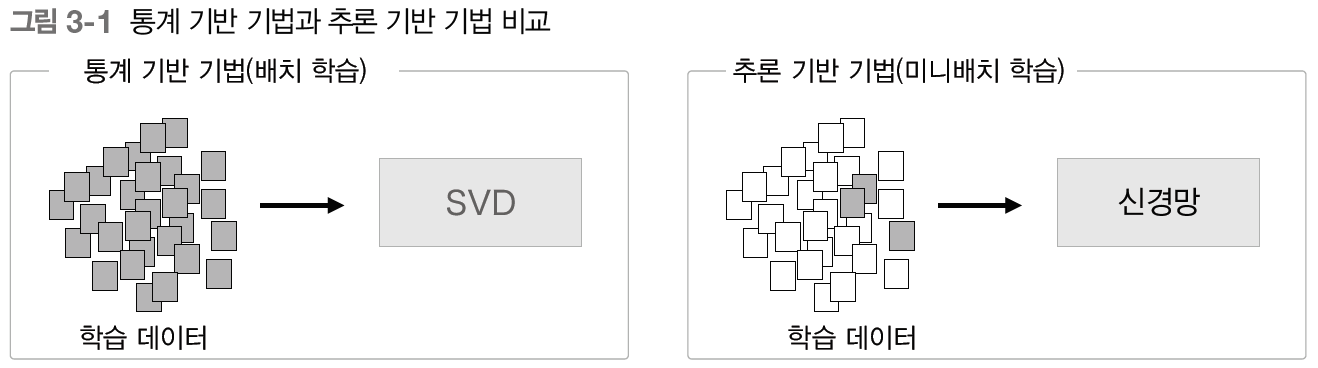

In [1]:
import os
from PIL import Image

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
img_path = os.path.join(parent_dir, 'images')

Image.open(os.path.join(img_path, 'fig 3-1.png'))

위 그림에서처럼 통계 기반 기법은 학습 데이터를 한꺼번에 처리한다(배치 학습).

이에 반해 추론 기반 기법은 학습 데이터의 일부를 사용하여 순차적으로 학습한다(미니배치 학습).

즉 말뭉치의 어휘 수가 많아 SVD 등 계산량이 큰 작업을 처리하기 어려운 경우에도 신경망 학습이 가능하다는 뜻이다.

게다가 여러 머신과 GPU를 이용한 병렬 계산도 가능하기에 학습 속도를 높일 수 있다.

### 3.1.2 추론 기반 기법 개요

추론이란 다음 그림처럼 주변 단어(맥락)가 주어졌을 때 "?"에 무슨 단어가 들어가는지를 추측하는 작업이다.

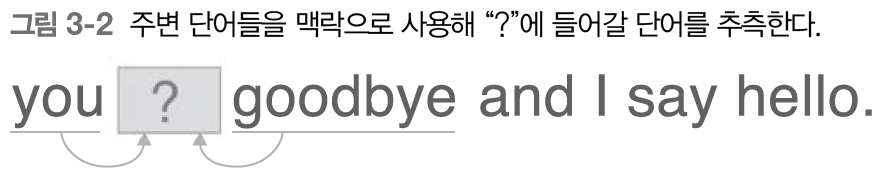

In [2]:
Image.open(os.path.join(img_path, 'fig 3-2.png'))

[그림 3-2]처럼 추론 문제를 풀고 학습하는 것이 '추론 기반 기법'이 다루는 문제이다.

이러한 추론 문제를 반복해서 풀면서 단어의 출현 패턴을 학습하는 것이다.

'모델 관점'에서 보면 추론 문제는 다음 그림과 같이 볼 수 있다.

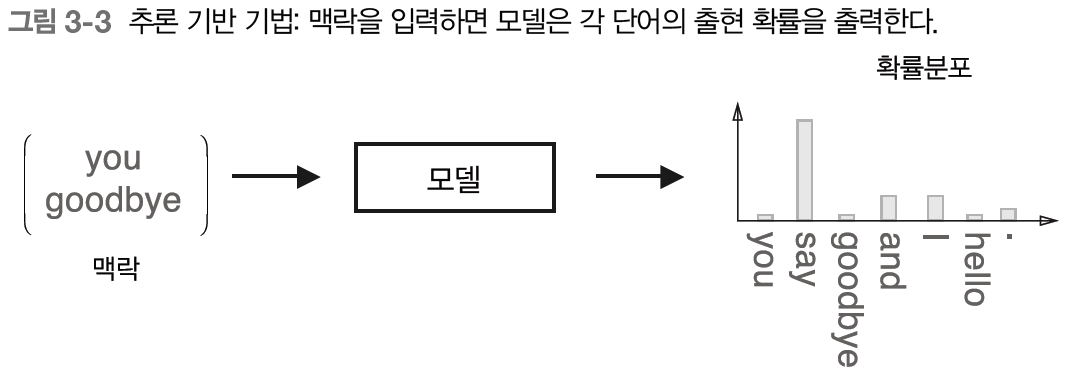

In [3]:
Image.open(os.path.join(img_path, 'fig 3-3.png'))

위 그림처럼 추론 기반 기법에는 어떤 모델이 등장하고, 우리는 이 모델로 신경망을 사용한다.
`
모델은 맥락 정보를 입력받아 (출현할 수 있는) 각 단어의 출현 확률을 출력한다.

이러한 틀 안에서 말뭉치를 사용해 모델이 올바른 추측을 내놓도록 학습시킨다.

그 학습의 결과로 단어의 분산 표현을 얻는 것이 추론 기반 기법의 핵심이다.

### 3.1.3 신경망에서의 단어 처리

신경망이 '단어'를 처리하게끔 하려면 단어를 '고정 길이의 벡터'로 변환해야 한다.

이때 사용하는 대표적인 방법으로 단어를 $\textbf{원핫}^{\text{one-hot}} \textbf{표현}$ 으로 변환하는 것이 있다.

"You say goodbye and I say hello." 문장에 대해 다음 그림과 같이 원핫 표현을 쓸 수 있다.

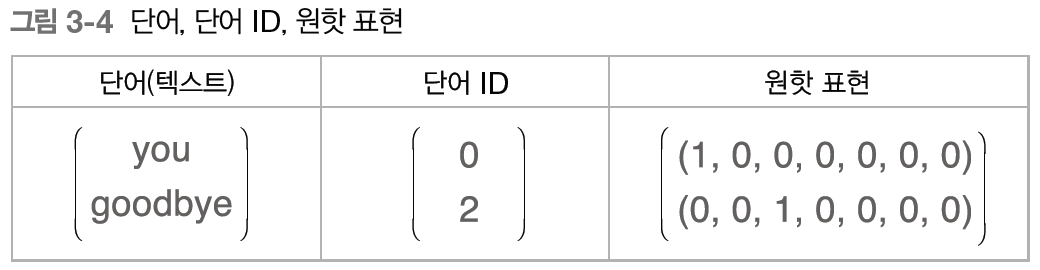

In [4]:
Image.open(os.path.join(img_path, 'fig 3-4.png'))

총 어휘 수만큼의 원소를 갖는 벡터를 준비하고, 인덱스가 단어 ID와 같은 원소를 1로, 나머지는 모두 0으로 설정한다.

이와 같이 단어를 고정 길이 벡터로 변환하면 신경망의 입력층을 다음 그림과 같이 고정시킬 수 있다.

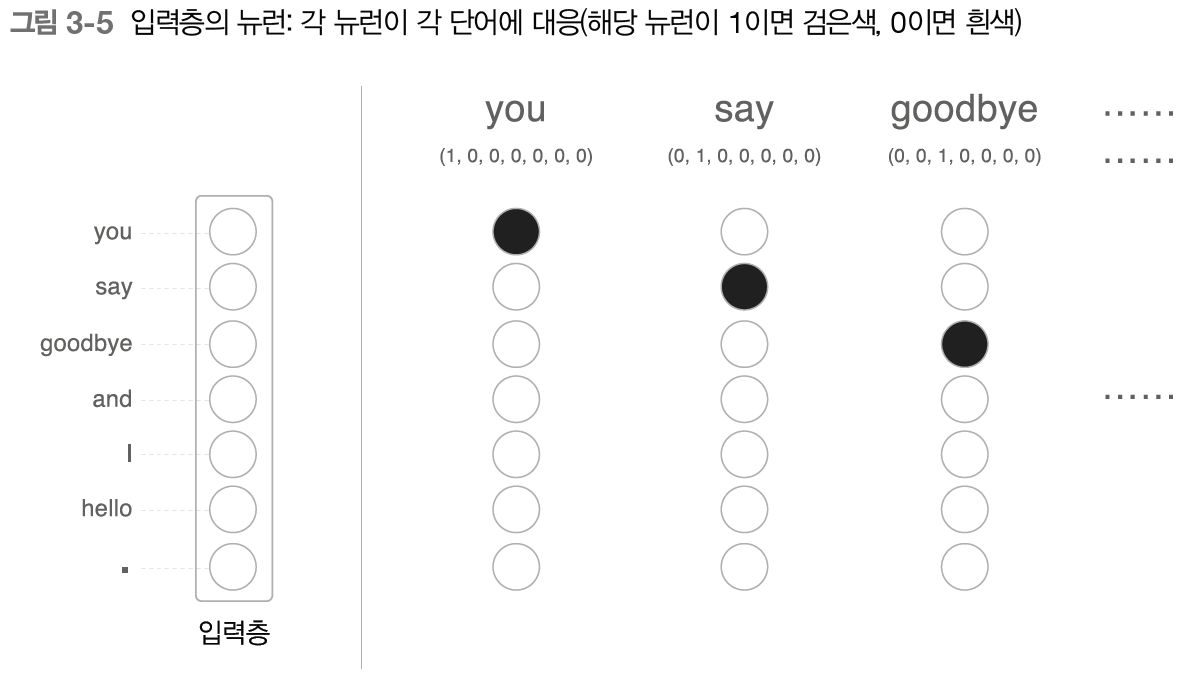

In [5]:
Image.open(os.path.join(img_path, 'fig 3-5.png'))

단어는 벡터로 나타낼 수 있고, 신경망을 구성하는 '계층'들은 벡터를 처리할 수 있다.

즉, 단어를 신경망으로 처리할 수 있다는 뜻이다. 다음 그림은 원핫 표현으로 된 단어 하나를 완전연결계층을 통해 변환하는 예시이다.

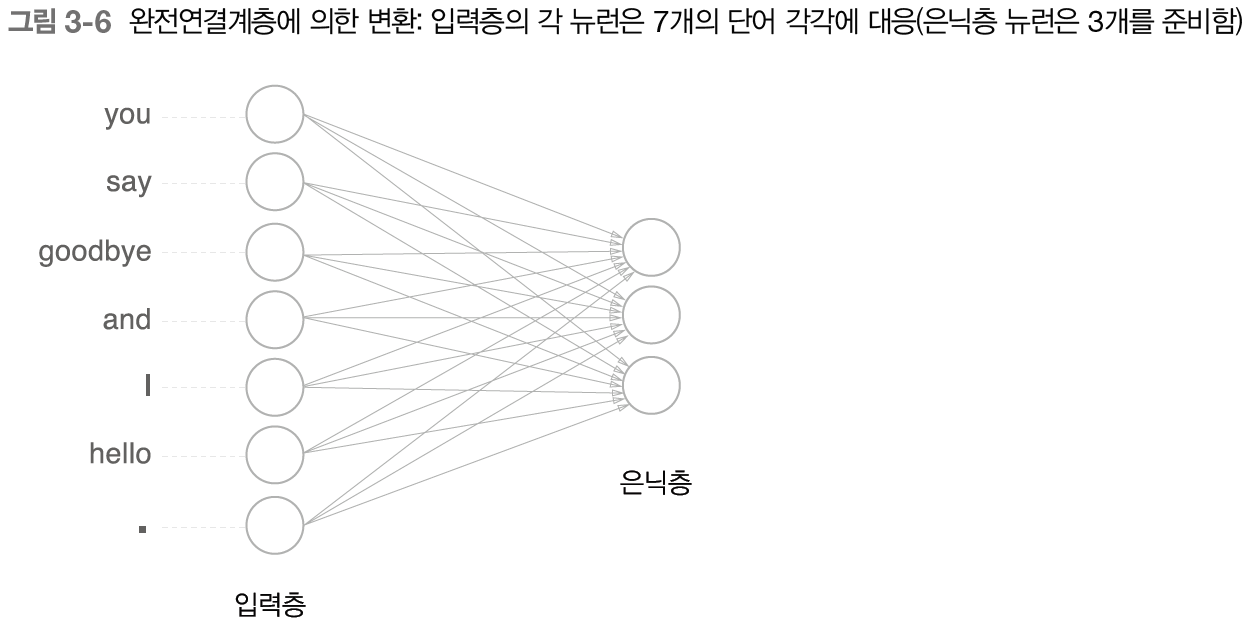

In [6]:
Image.open(os.path.join(img_path, 'fig 3-6.png'))

위 그림에서는 뉴런 사이의 결합을 화살표로 표시했으나, 이후로는 가중치를 명확하게 하기 위해 다음 그림처럼 그린다.

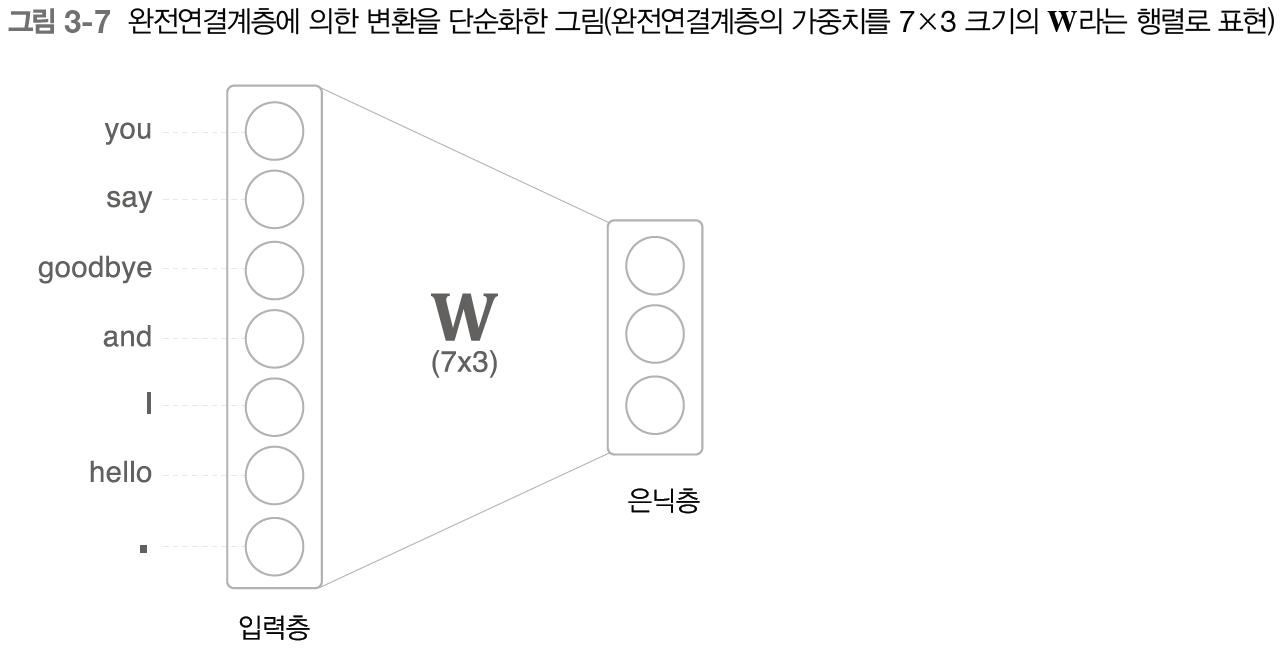

In [7]:
Image.open(os.path.join(img_path, 'fig 3-7.png'))

파이썬 코드로 다음과 같이 쓸 수 있다.

In [8]:
import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]])   # 입력
W = np.random.randn(7, 3)   # 가중치
h = np.matmul(c, W)   # 중간 노드
# h_dot = np.dot(c, W)   # 중간 노드
print(h)
# print(h_dot)

[[0.27665109 1.40379516 0.11583121]]


$\textbf{WARNING}$

이 코드에서 입력 데이터 `c` 의 차원 수(`ndim`)는 2이다. 이는 미니배치 처리를 고려한 것으로, 최초의 차원(0번째 차원)에 각 데이터를 저장한다.

앞의 코드의 의미는 다음 그림과 같이 가중치의 행벡터 하나를 '뽑아내는' 것과 같다.

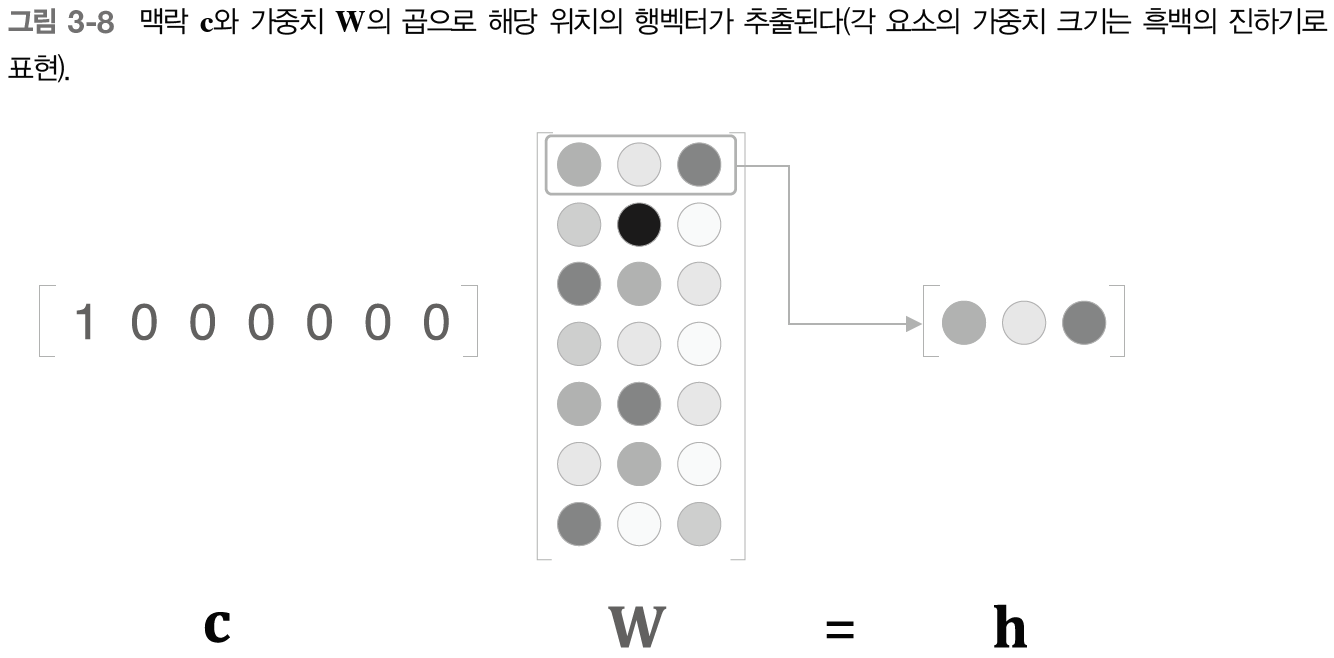

In [9]:
Image.open(os.path.join(img_path, 'fig 3-8.png'))

앞선 코드는 1장에서 구현한 `MatMul` 계층으로도 수행 가능하다.

In [10]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

c = np.array([[1, 0, 0, 0, 0, 0, 0]])   # 입력
W = np.random.randn(7, 3)   # 가중치
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[0.09186619 0.39288239 0.41218628]]


## 3.2 단순한 word2vec

지금부터는 [그림 3-3]의 '모델'을 신경망으로 구축해본다. 사용하는 신경망은 word2vec에서 제안하는 $\textbf{CBOW}^{\text{continuous bag-of-words}}$ 이다.

### 3.2.1 CBOW 모델의 추론 처리

CBOW 모델은 맥락으로부터 타깃(target)을 추측하는 용도의 신경망이다('타깃'은 중앙 단어이고 그 주변 단어들이 '맥락').

우리는 이 CBOW 모델이 가능한 한 정확하게 추론하도록 훈련시켜서 단어의 분산 표현을 얻어내고자 한다.

CBOW 모델의 입력은 맥락이다. 맥락은 'you'와 'goodbye'같은 단어들의 목록이다.

먼저, 이 맥락을 원핫 표현으로 변환하여 CBOW 모델이 처리할 수 있도록 준비한다.

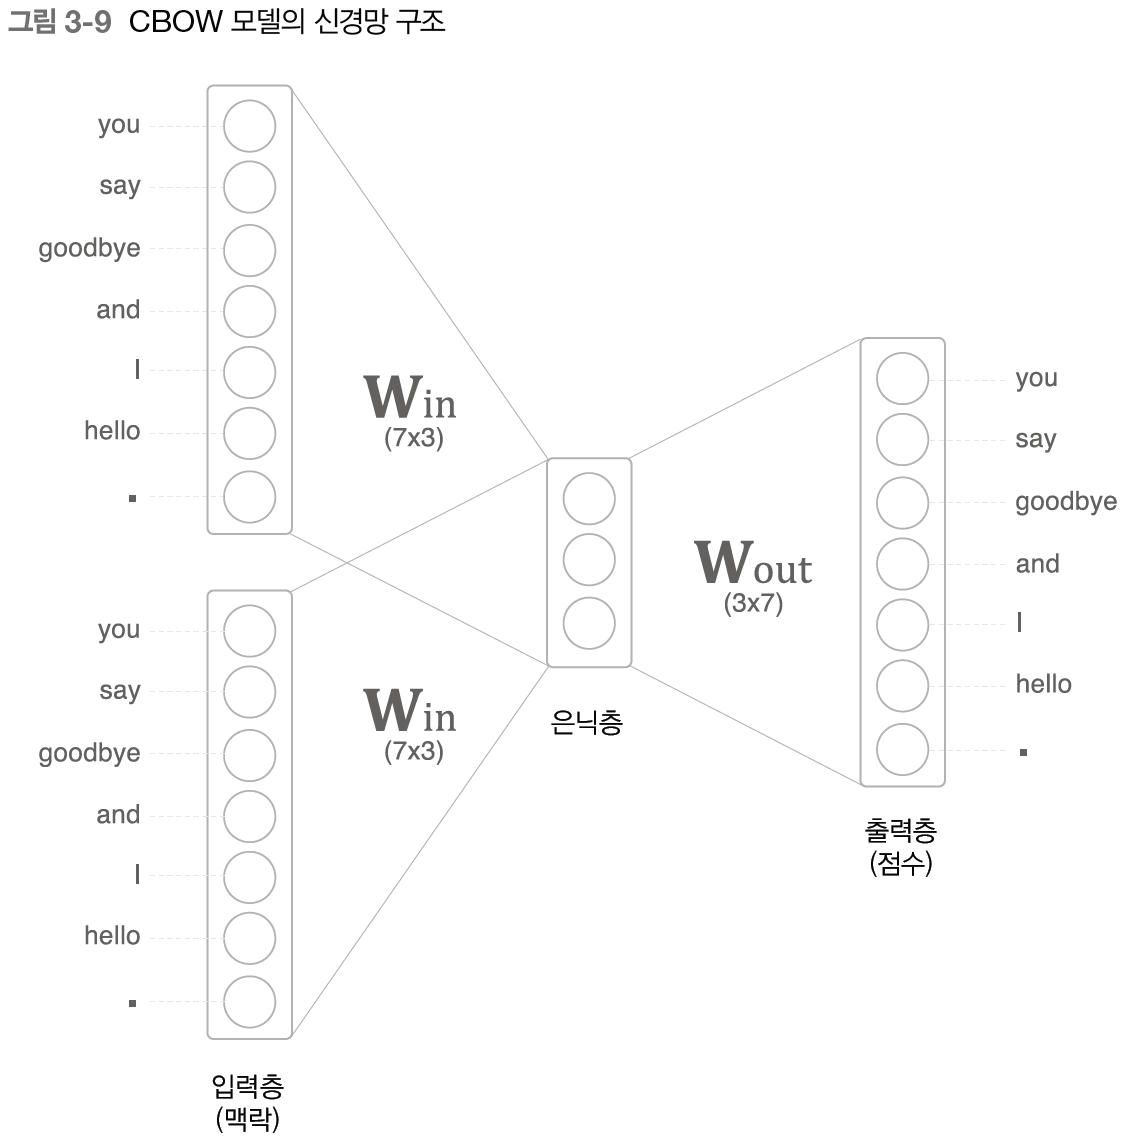

In [11]:
Image.open(os.path.join(img_path, 'fig 3-9.png'))

$\textbf{WARNING}$

이 그림에서 입력층이 2개인 이유는 맥락으로 고려할 단어를 2개로 정했기 때문이다. 즉, 맥락에 포함시킬 단어가 $N$ 개 라면 입력층도 $N$ 개가 된다.

[그림 3-9]의 은닉층에 주목한다.

은닉층의 뉴런값은 입력층이 여러 개인 경우 전체를 '평균'하면 된다.

예를 들어 완전연결계층에 의한 첫 번째 입력층이 $\mathbf{h}_1$ 으로 변환되고, 두 번째 입력층이 $\mathbf{h}_2$ 로 변환되면 은닉층 뉴런은 $\tfrac{1}{2} (\mathbf{h}_1 + \mathbf{h}_2)$ 가 된다.

출력층의 뉴런은 총 7개인데, 각 뉴런 하나하나가 각각의 단어에 대응한다.

그리고 출력층 뉴런은 각 단어의 '점수'를 뜻하며, 값이 높을수록 대응 단어의 출현 확률도 높아진다.

이 점수에 소프트맥스 함수를 적용하면 '확률'을 얻는다.

또한 입력층에서 은닉층오릐 변환은 완전연결계층(가중치는 $\mathbf{W}_{\text{in}}$) 에 의해서 이뤄진다.

이때 완전연결계층의 가중치 $\mathbf{W}_{\text{in}}$ 은 $7 \times 3$ 행렬이며, (미리 밝히자면) 이 가중치가 바로 단어의 분산 표현의 정체이다.

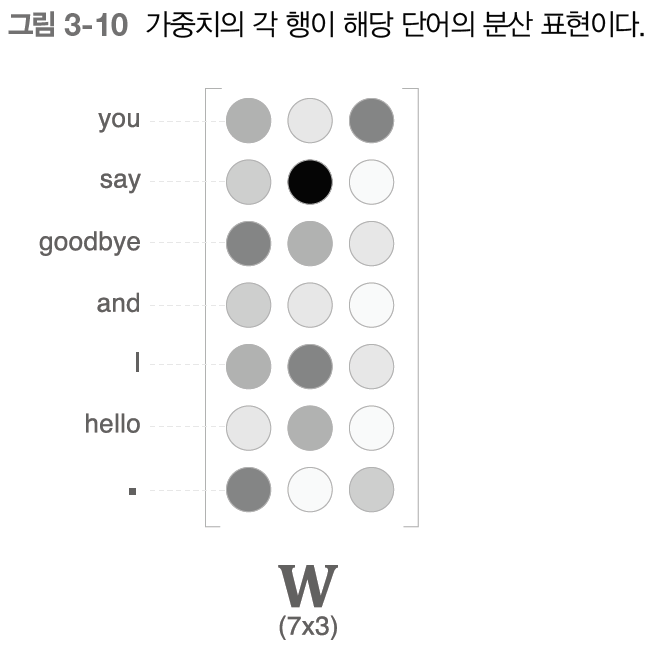

In [12]:
Image.open(os.path.join(img_path, 'fig 3-10.png'))

위 그림에서 보듯 가중치 $\mathbf{W}_{\text{in}}$ 의 각 행에는 해당 단어의 분산 표현이 담겨 있다고 볼 수 있다.

따라서 학습을 진행할수록 맥락에서 출현하는 단어를 잘 추측하는 방향으로 이 분산 표현들이 갱신된다.

이렇게 해서 얻은 벡터에는 '단어의 의미'도 잘 녹아들어 있다!

$\textbf{NOTE}$

은닉층의 뉴런 수를 입력층의 뉴런 수보다 적게 하는 것이 중요한 핵심이다. 이렇게 해야 은닉층에는 단어 예측에 필요한 정보를 '간결하게' 담게 되며, 결과적으로 밀집벡터 표현을 얻을 수 있다. 이때 그 은닉층의 정보는 우리 인간은 이해할 수 없는 코드로 쓰여 있다. 바로 '인코딩'에 해당한다. 한편, 은닉층의 정보로부터 원하는 결과를 얻는 작업은 '디코딩'이라고 한다. 즉, 디코딩이란 인코딩된 정보를 우리 인간이 이해할 수 있는 표현으로 복원하는 작업이다.

다음 그림은 신경망을 계층 관점에서 그린 모습이다.

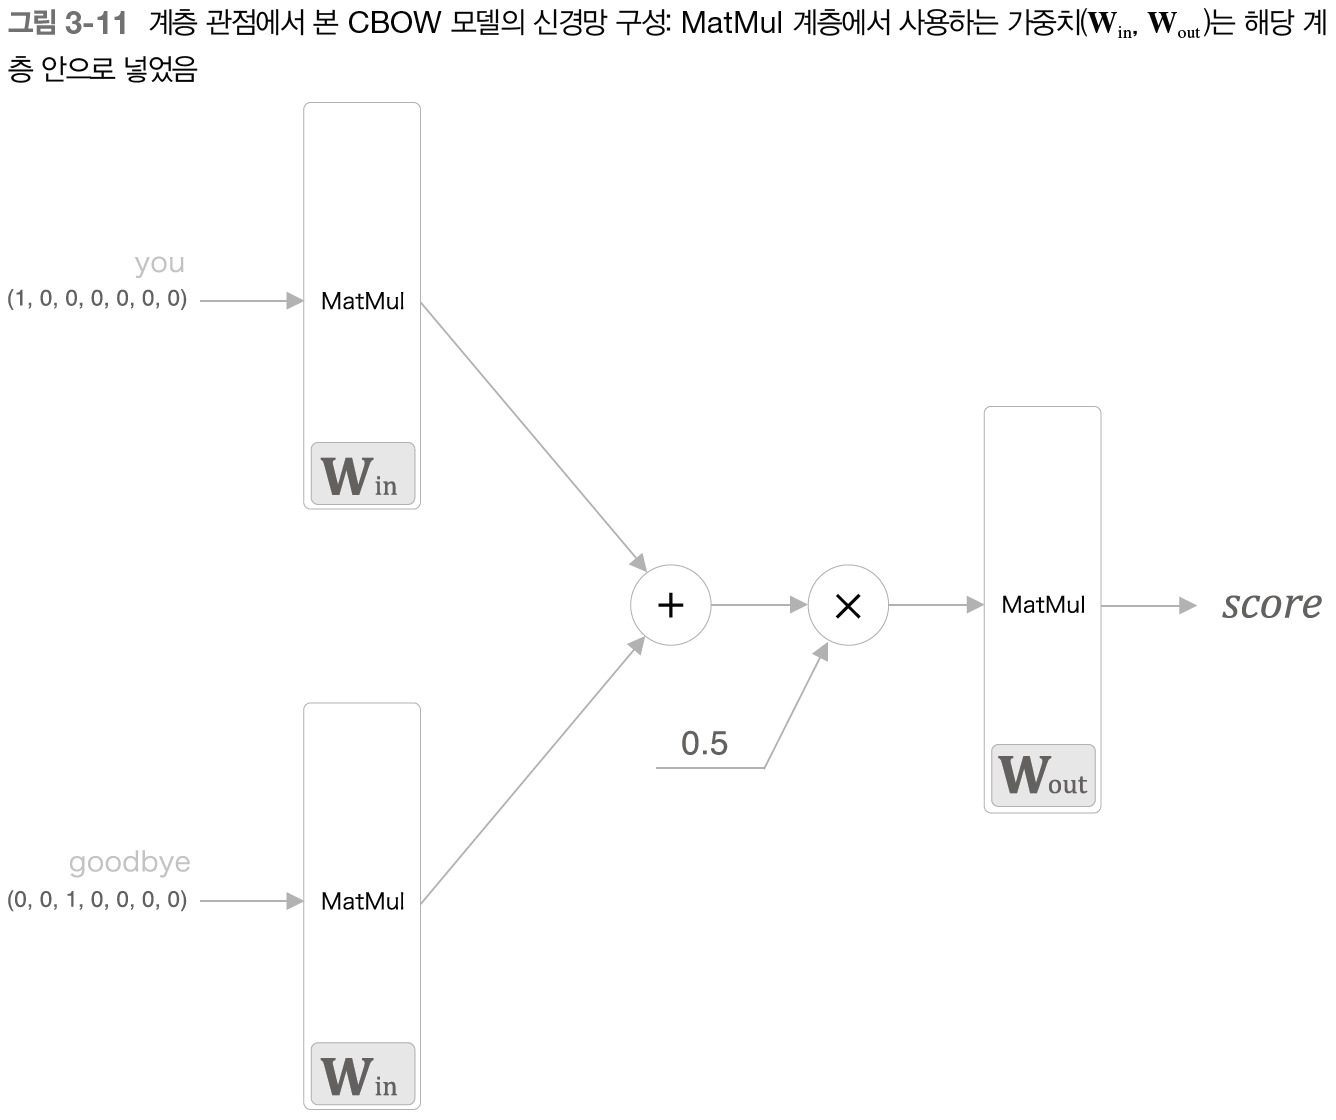

In [13]:
Image.open(os.path.join(img_path, 'fig 3-11.png'))

그림에서 알 수 있듯이, CBOW 모델의 가장 앞단에는 2개의 MatMul 계층이 있다.

이어서 이 두 계층의 출력이 더해진다.

그리고 더해진 값에 0.5를 곱하면 '평균'이 되며, 이 평균이 은닉층 뉴런이 된다.

마지막으로 은닉층 뉴런에 또 다른 MatMul 계층이 적용되어 '점수'가 출력된다.

[그림 3-11]을 참고하여, CBOW 모델의 추론 처리를 파이썬으로 구현할 수 있다. (chapter03/cbow_predict.py)

이상이 CBOW 모델의 추론 과정이다

CBOW 모델은 활성화 함수를 사용하지 않는 간단한 구성의 신경망이다.

입력층이 여러 개 있고 그 입력층들이 가중치를 공유한다는 점을 제외하고는 어려운 점은 없다.

### 3.2.2 CBOW 모델의 학습

지금까지 설명한 CBOW 모델은 출력층에서 각 단어의 점수를 출력했다.

이 점수에 소프트맥스 함수를 적용하면 '확률'을 얻을 수 있다.

이 확률은 맥락(전후 단어)이 주어졌을 때 그 중앙에 어떤 단어가 출현하는지를 나타낸다.

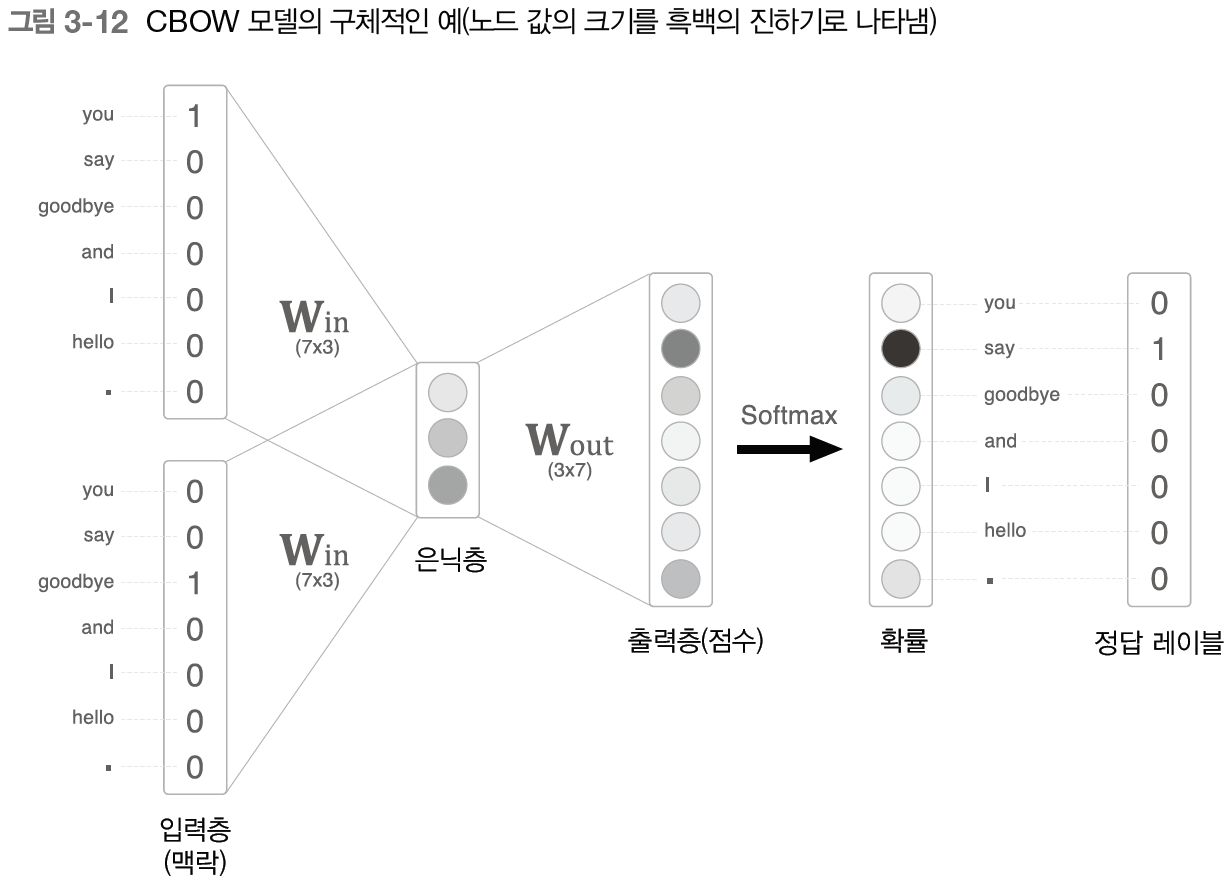

In [14]:
Image.open(os.path.join(img_path, 'fig 3-12.png'))

그림의 예에서 맥락은 'you'와 'goodbye'이고, 정답 레이블(신경망이 예측해야 할 단어)은 'say'이다.

이때 '가중치가 적절히 설정된' 신경망이라면 '확률'을 나타내는 뉴런들 중 정답에 해당하는 뉴런의 값이 클 것이라고 기대할 수 있다.

CBOW 모델의 학습에서는 올바른 예측을 할 수 있도록 가중치를 조정하는 일을 한다.

그 결과로 가중치에 단어의 출현 패턴을 파악한 벡터가 학습된다.

지금까지의 실험에 의하면 CBOW 모델과 skip-gram 모델로 얻을 수 있는 단어의 분산 표현은 단어의 의미 면에서나 문법 면에서 모두 우리의 직관에 부합하는 경우를 많이 볼 수 있다.

$\textbf{NOTE}$

CBOW 모델은 단어 출현 패턴을 학습 시 사용한 말뭉치로부터 배운다. 따라서 말뭉치가 달라지면 학습 후 얻게 되는 단어의 분산 표현도 달라진다. 예컨대 말뭉치로 '스포츠'기사만을 사용하는 경우와 '음악'관련 기사만을 사용하는 경우 얻게 되는 단어의 분산 표현이 크게 달라지게 된다.

우리가 다루고 있는 모델은 다중 클래스 분류를 수행하는 신경망이다.

따라서 이 신경망을 학습하려면 소프트맥스와 교차 엔트로피 오차만 사용하면 된다.

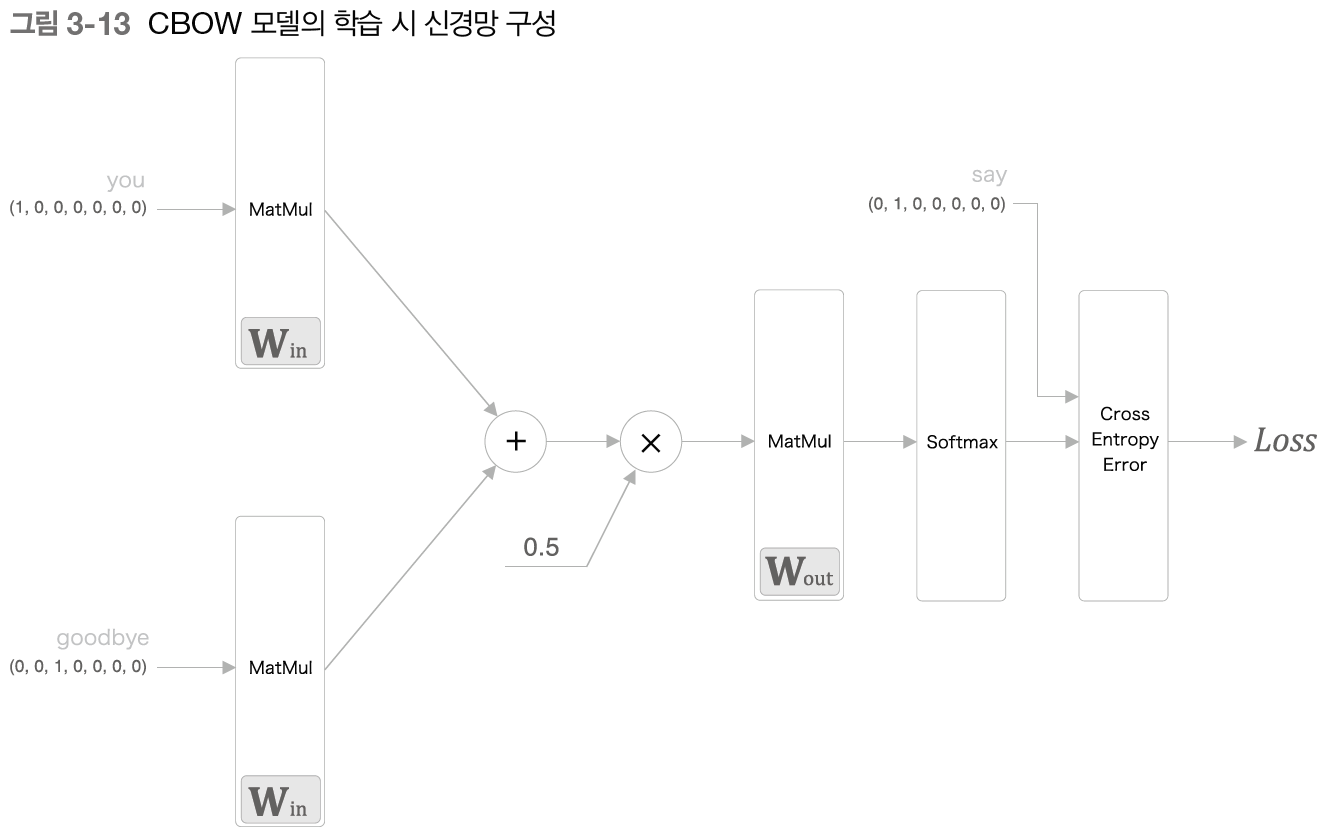

In [15]:
Image.open(os.path.join(img_path, 'fig 3-13.png'))

앞서 Softmax 계층과 Cross Entropy Error 계층을 Softmax with Loss 라는 하나의 계층으로 구현했었기에, 앞으로 구현할 신경망의 정확한 모습은 다음과 같다.

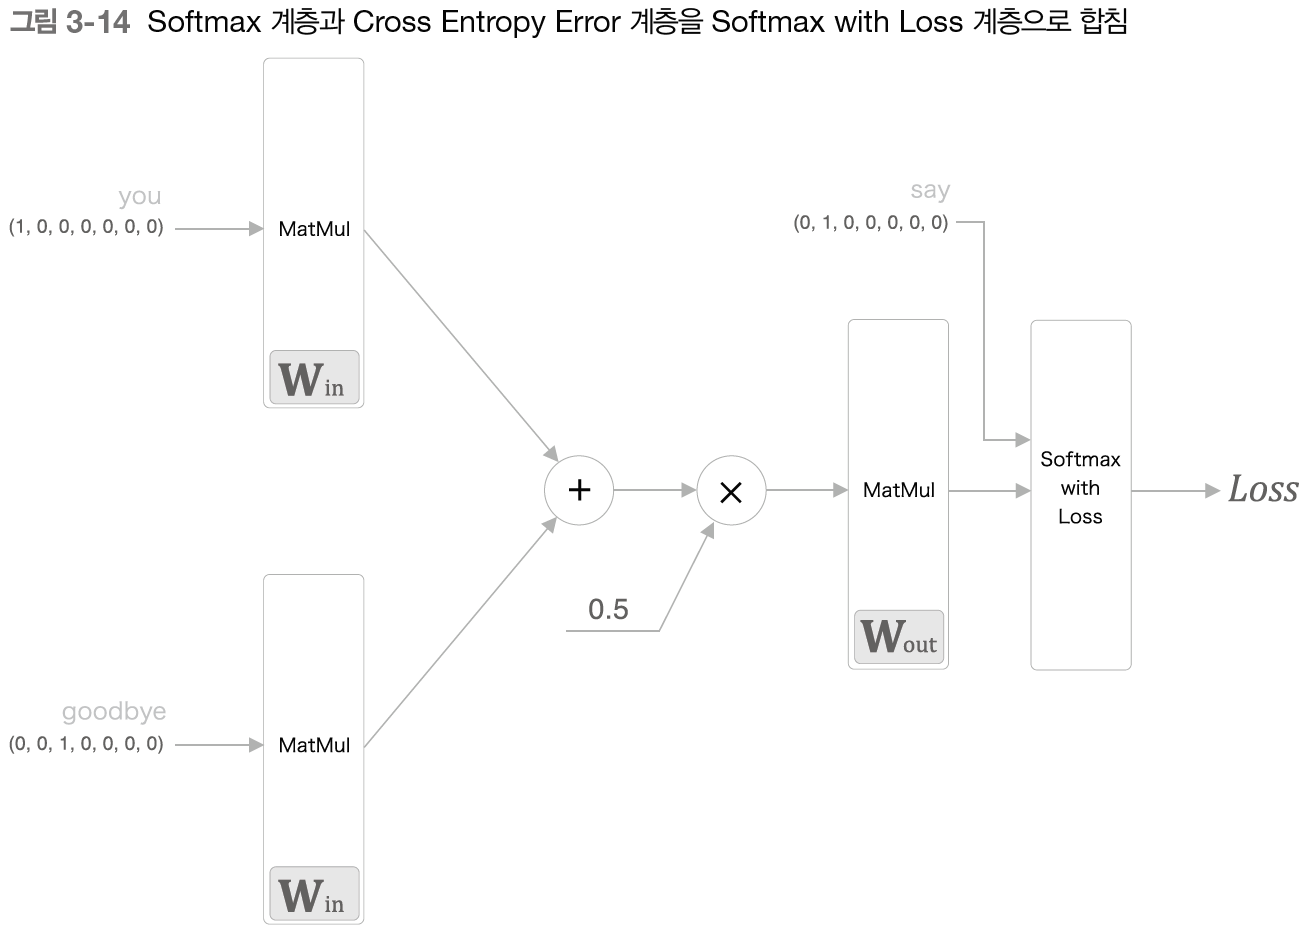

In [16]:
Image.open(os.path.join(img_path, 'fig 3-14.png'))

### 3.2.3 word2vec의 가중치와 분산 표현

word2vec에서 사용되는 신경망에는 두 가지 가중치가 있다.

$\mathbf{W}_{\text{in}}$ : 입력 측 완전연결계층 가중치. 각 행이 각 단어의 분산 표현에 해당

$\mathbf{W}_{\text{out}}$ : 출력 측 완전연결계층 가중치. 각 열이 각 단어의 분산 표현에 해당

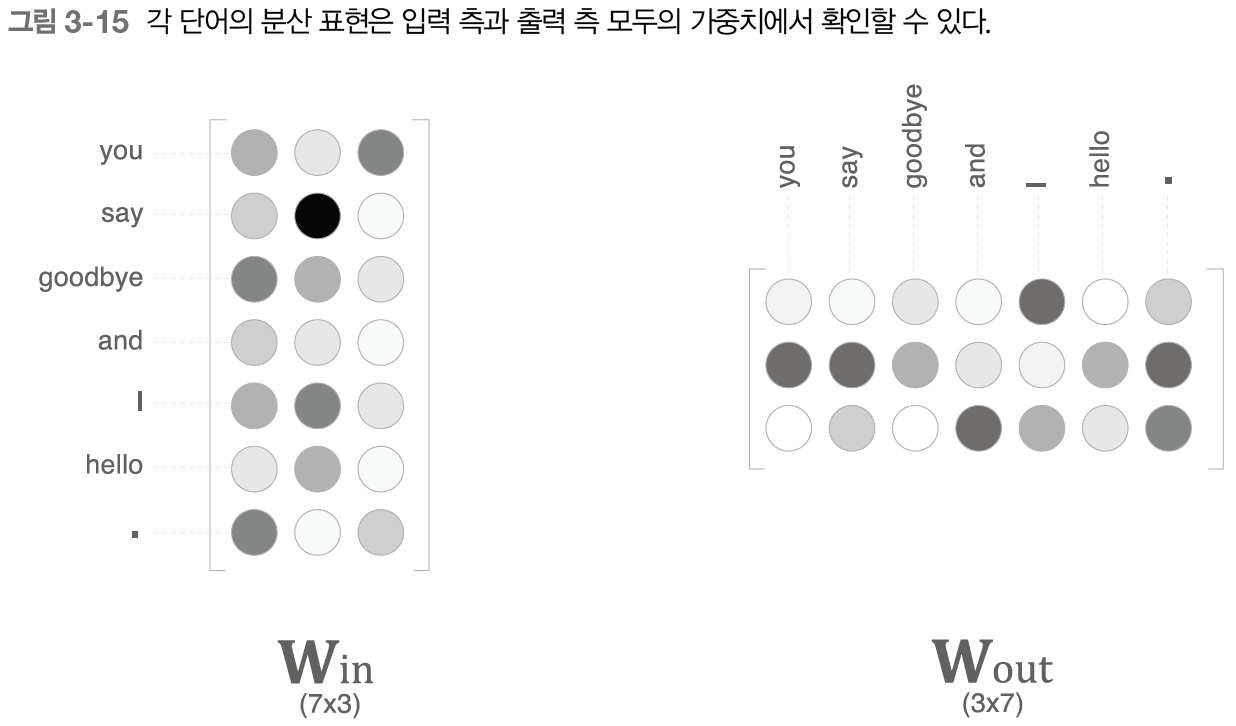

In [17]:
Image.open(os.path.join(img_path, 'fig 3-15.png'))

그러면 최종적으로 단어의 분산 표현으로 가중치를 선택하는 방법은 다음과 같이 세 가지가 있다.

1. 입력 측의 가중치만 이용한다.
2. 출력 측의 가중치만 이용한다.
3. 양쪽 가중치를 모두 이용한다.

word22vec(특히 skip-gram 모델)에서는 첫 번째인 '입력 측의 가중치만 이용한다'가 대중적인 선택이다.

많은 연구에서 출력 측 가중치는 버리고 입력 측 가중치 $\mathbf{W}_{\text{in}}$ 만을 최종 단어의 분산 표현으로서 이용한다.

우리도 입력 측 가중치만을 단어의 분산 표현으로 이용하고자 한다.

${\textbf{NOTE}}$

문헌[38] 에서는 word2vec의 skip-gram 모델을 대상으로 $\mathbf{W}_{\text{in}}$ 의 효과를 실험을 통해 보여준다. 한편, word2vec과 비슷한 기법인 GloVe 에서는 두 가중치를 더했을 때 좋은 결과를 얻었다.

## 3.3 학습 데이터 준비

사용하는 데이터는 "You say goodbye and I say hello."

### 3.3.1 맥락과 타깃

word2vec에서 이용하는 신경망의 입력은 '맥락'이다.

정답 레이블은 맥락에 둘러싸인 중앙의 단어, 즉 '타깃'이다.

우리가 해야 할 일은 신경망에 '맥락'을 입력했을 때 '타깃'이 출현할 확률을 높이는 것이다.

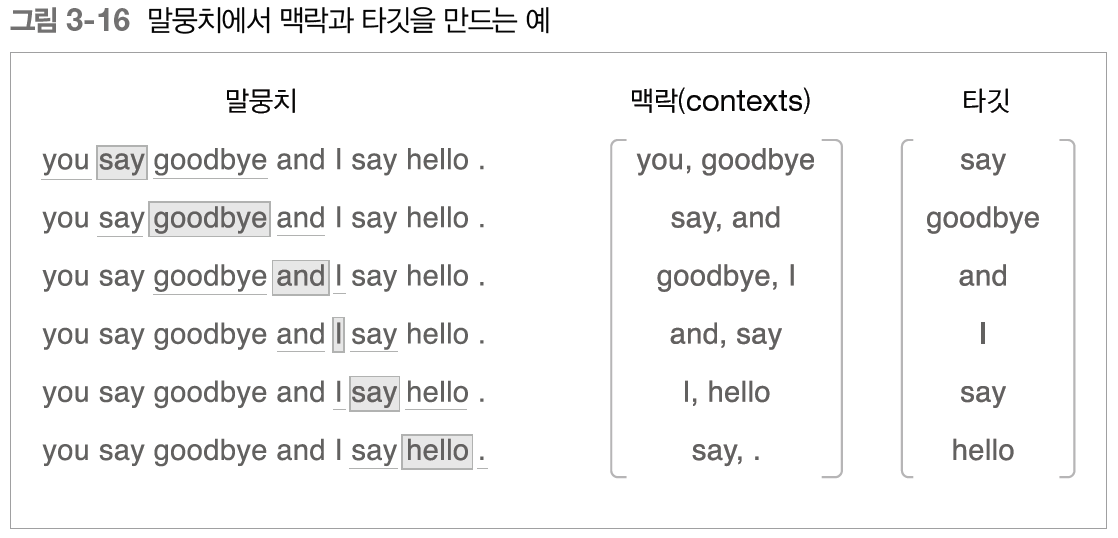

In [18]:
Image.open(os.path.join(img_path, 'fig 3-16.png'))

그림을 보면 말뭉치로부터 목표로 하는 단어를 '타깃'으로, 그 주변 단어를 '맥락'으로 뽑아낸다.

이 작업을 말뭉치 안의 (양끝 단어는 제외한) 모든 단어에 대해 수행한다.

이렇게 만들어진 '맥락'이 신경망의 입력으로 쓰이고 '타깃'이 정답 레이블이 된다.

이제 말뭉치로부터 맥락과 타깃을 만드는 함수를 구현해야 하는데, 먼저 말뭉치 텍스트를 단어 ID로 변환해야 한다.

In [19]:
import sys
sys.path.append('..')
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


그런 다음 다음과 같이 단어 ID의 배열인 corpus로부터 맥락과 타깃을 만든다.

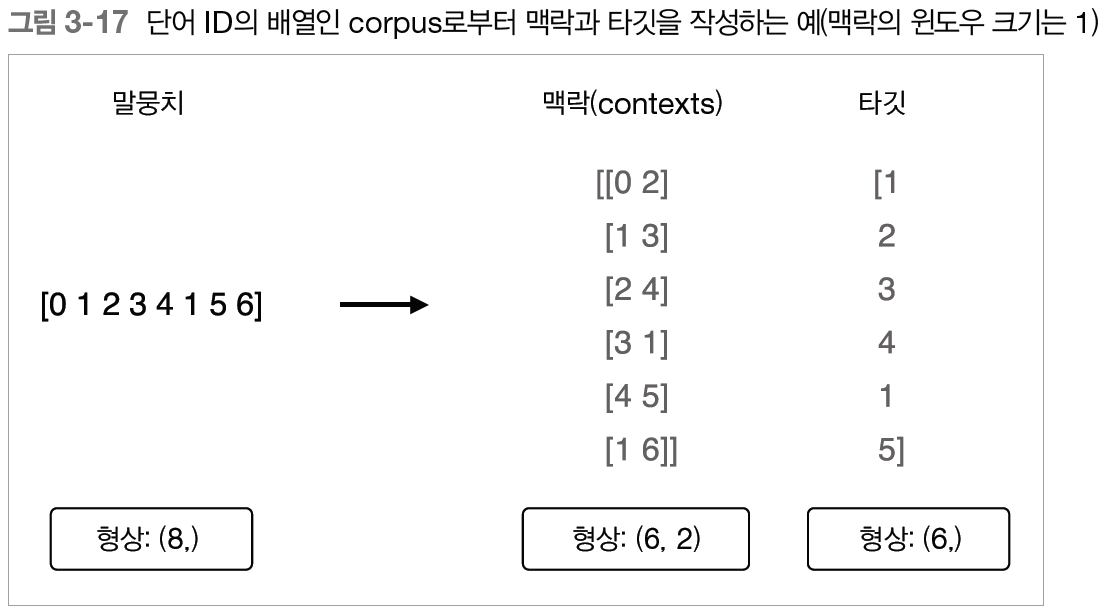

In [20]:
Image.open(os.path.join(img_path, 'fig 3-17.png'))

이제 맥락과 타깃을 만드는 함수를 구현한다 (`create_contexts_target(corpus, window_size)`).

이 함수는 인수를 두 개 받는다. 하나는 단어 ID의 배열(corpus), 다른 하나는 맥락의 윈도우 크기(window_size)이다. 그리고 맥락과 타깃을 각각 넘파이 다차원 배열로 돌려준다.

In [21]:
import sys
sys.path.append('..')
from common.util import create_contexts_target

contexts, target = create_contexts_target(corpus, window_size=1)

print(contexts)

print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


### 3.3.2 원핫 표현으로 변환

계속해서 맥락과 타깃을 원핫 표현으로 바꾸면 다음 그림과 같이 할 수 있다.

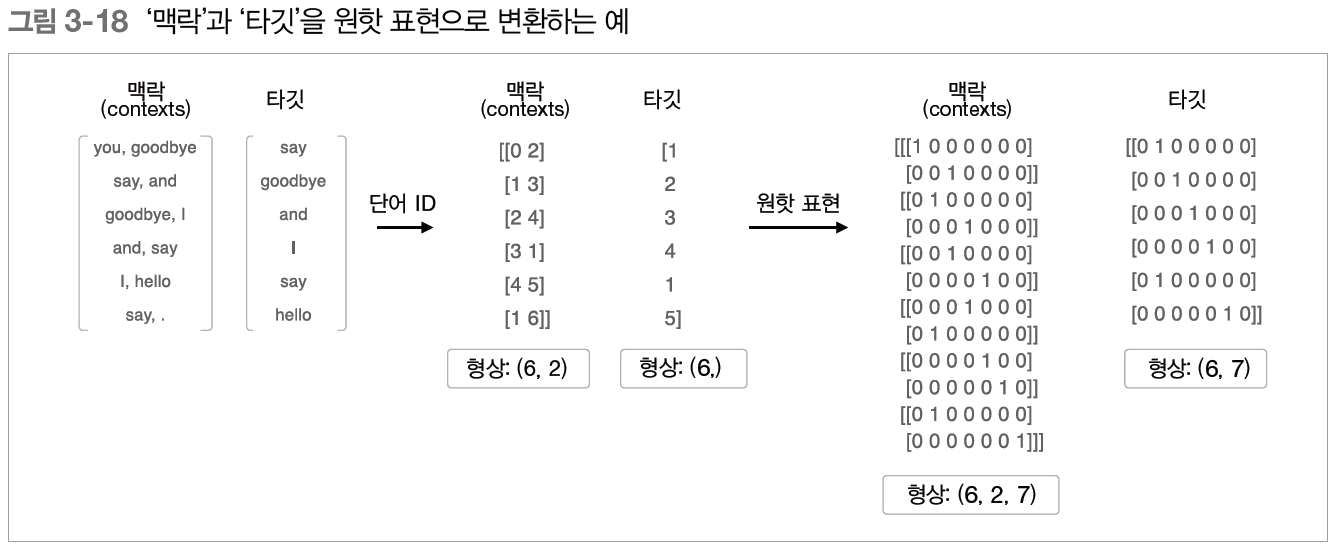

In [22]:
Image.open(os.path.join(img_path, 'fig 3-18.png'))

그림처럼 맥락과 타깃을 단어 ID에서 원핫 표현으로 변환할 수 있다.

이때 다시 한번 각각의 다차원 배열의 형상에 주목해야 한다.

잘 보면, 이 그림에서는 단어 ID를 이용했을 때의 맥락의 형상은 (6,2)인데, 이를 원핫 표현으로 변환하면 (6,2,7)이 된다.

원핫 표현으로의 변환은 `convert_one_hot()` 함수를 사용한다.

이 함수는 인수로 '단어 ID 목록'과 '어휘 수'를 받는다.

In [23]:
import sys
sys.path.append('..')   
from common.util import convert_one_hot, preprocess, create_contexts_target

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

print(f"target: {target}")
print(f"contexts: {contexts}")

target: [[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
contexts: [[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


## 3.4 CBOW 모델 구현

CBOW 모델을 구현하고자 한다. 구현하는 신경망은 다음 그림과 같다.

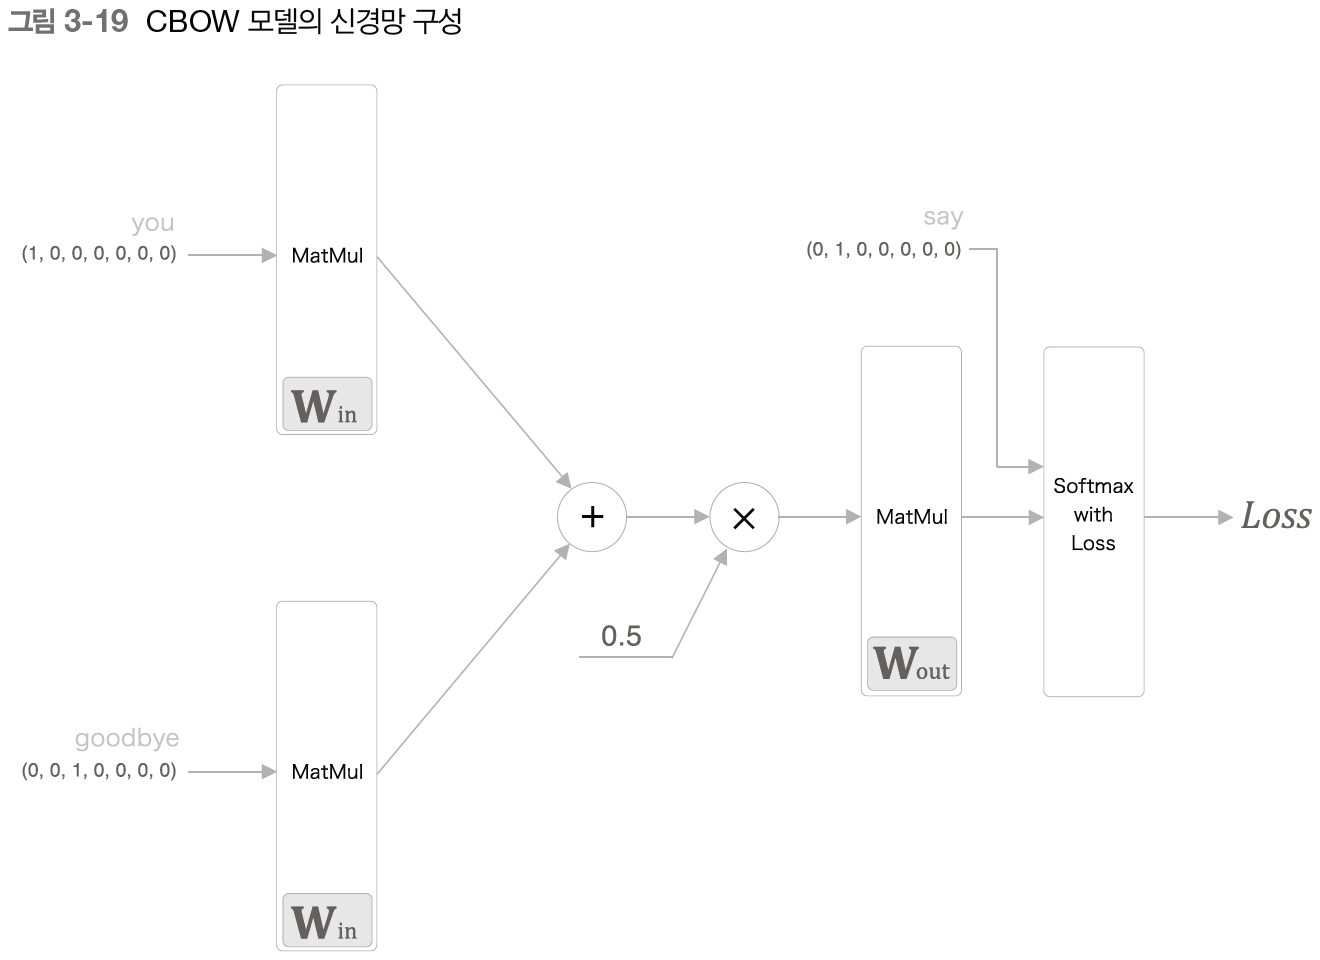

In [24]:
Image.open(os.path.join(img_path, 'fig 3-19.png'))

이 그림의 신경망을 SimpleCBOW라는 이름으로 구현해본다 (chapter03/simple_cbow.py)

$\textbf{WARNING}$

이 코드에서는 여러 계층에서 같은 가중치를 공유한다. 따라서 `params` 리스트에는 같은 가중치가 여러 개 존재하게 되는데, 이렇게 되면 Adam 이나 Momentum 등의 옵티마이저 처리가 본래의 동작과 달라지게 된다(적어도 지금과 같은 구현에서는 그렇다). 그래서 `Trainer` 클래스 내부에서는 매개변수를 갱신할 때 매개변수의 중복을 없애는 간단한 작업을 수행하도록 한다. (`remove_duplicate(params, grads)`)

이 신경망의 역전파 계산 그래프는 다음과 같다.

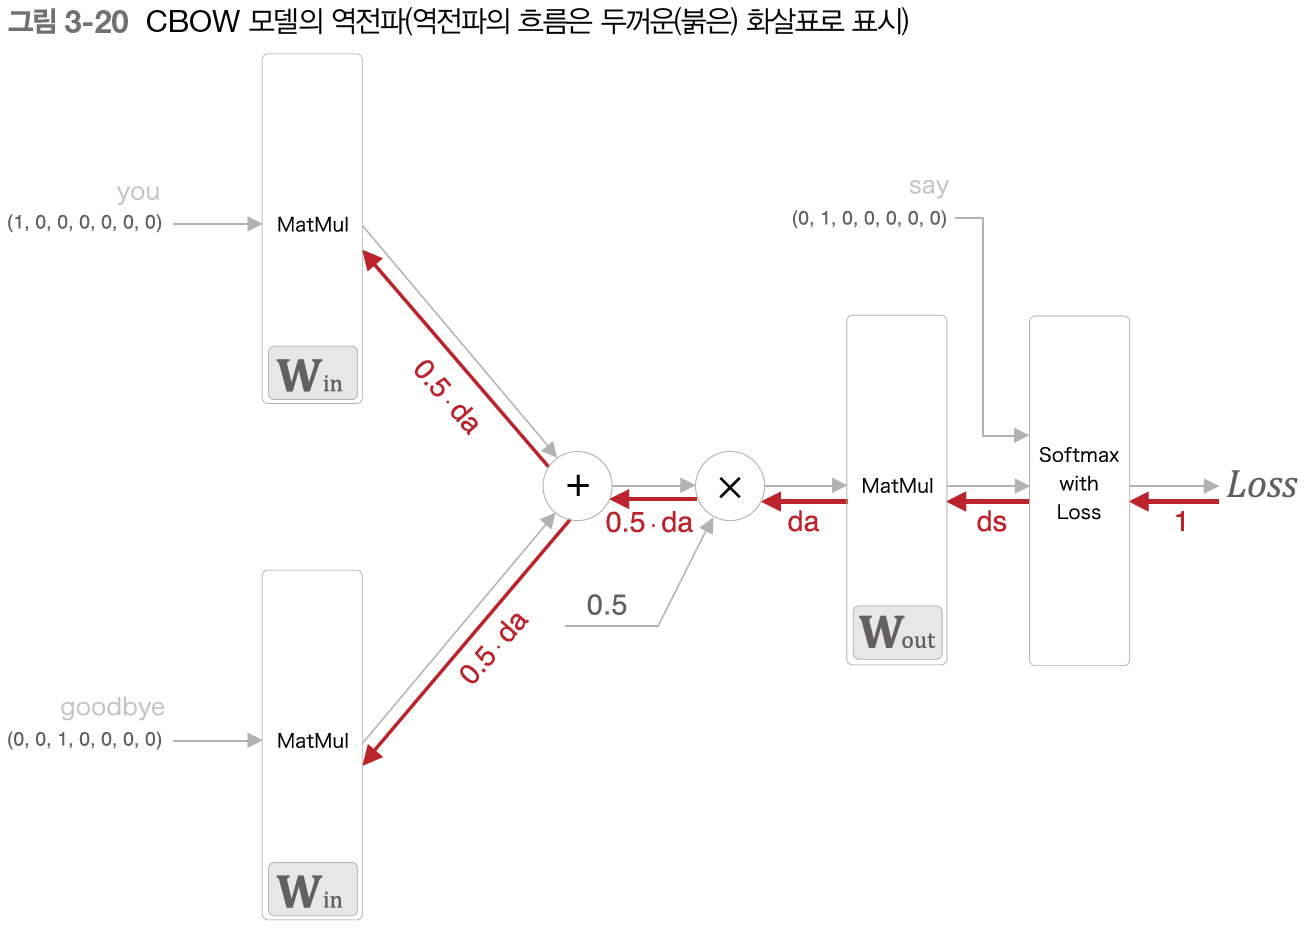

In [25]:
Image.open(os.path.join(img_path, 'fig 3-20.png'))

이것으로 역전파 구현까지 모두 마쳤다.

각 매개변수의 기울기를 인스턴스 변수 `grads`에 모아두었다.

따라서 `forward()` 메서드를 호출한 다음 `backward()` 메서드를 실행하는 것만으로 `grads` 리스트의 기울기가 갱신된다.

### 3.4.1 학습 코드 구현

CBOW 모델의 학습은 일반적인 신경망과 완전히 같다.

학습 데이터를 준비해서 신경망에 입력한 다음, 기울기를 구하고 가중치 매개변수를 순서대로 갱신해나간다.

학습 코드는 chapter03/train.py 에 있다. 실행 결과는 다음과 같다.

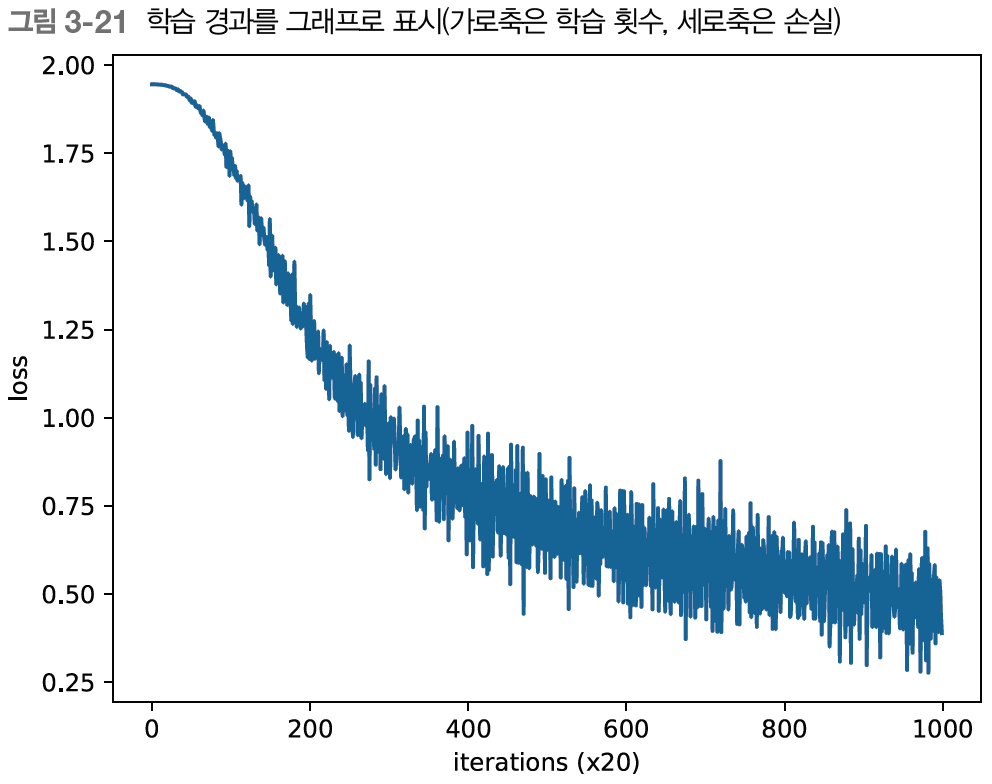

In [26]:
Image.open(os.path.join(img_path, 'fig 3-21.png'))

보다시피 학습을 거듭할수록 손실이 줄어드는 것을 알 수 있다.

입력 측 MatMul 계층의 가중치를 꺼내서 실제 내용을 확인해보면 다음과 같다.

```
you [-0.56185704 -0.9802071  -1.1151379   1.0957973   1.7520368 ]
say [ 1.2300115   1.1128904   0.36587408 -1.0984569  -1.2035049 ]
goodbye [-1.2209406 -1.0436382 -0.869835   0.9310466 -0.6523358]
and [ 1.0529583  1.0236835 -2.1732528 -1.1322929 -0.8208814]
i [-1.1987813  -1.0372839  -0.8805636   0.9386298  -0.63431865]
hello [-0.56457067 -0.9734643  -1.1383406   1.0730085   1.7347641 ]
. [ 1.0670348   0.86770725  1.7066708  -0.40032297 -1.2656883 ]
```

마침내 단어를 밀집벡터로 나타낼 수 있게 되었다.

이 밀집벡터가 바로 단어의 분산 표현이다.

학습이 잘 이뤄졌으니 이 분산 표현은 '단어의 의미'를 잘 파악한 벡터 표현으로 되어 있을 것이라 기대할 수 있다.

하지만 여기서 다룬 작은 말뭉치로는 좋은 결과를 얻기 어렵다.

실용적이고 충분히 큰 말뭉치로 바꾸면 결과도 그만큼 좋아지겠지만, 현재의 코드로는 처리 속도 면에서 문제가 생긴다.

그래서 다음 장에서는 현재의 '단순한' CBOW 모델을 개선하여 '진짜' CBOW 모델을 구현하고자 한다.

## 3.5 word2vec 보충

CBOW 모델을 '확률' 관점에서 다시 살펴보고자 한다.

### 3.5.1 CBOW 모델과 확률



먼저 '확률'의 표기법을 간단하게 소개한다.

이 책에서는 확률을 $P(\cdot)$ 으로 쓴다. $A$ 라는 현상이 일어날 확률을 $P(A)$ 로 쓰는 것이다.

$P(A, B)$ : A와 B가 동시에 일어날 확률. $(\textbf{동시 확률})$

$P(A | B)$ : $B$ 가 일어난 후(주어졌을 때) $A$의 확률. $( \textbf{사후확률} )$

CBOW 모델을 확률 표기법으로 써보도록 한다.

CBOW 모델이 하는 일은 맥락을 주면 타깃 단어가 출현할 확률을 출력하는 것이다.

여기서 말뭉치는 $w_1, w_2, \cdots, w_T$ 처럼 단어 시퀀스로 표기하고 다음 그림과 같이 $t$ 번째 단어에 대해 윈도우 크기가 1인 맥락을 고려한다.

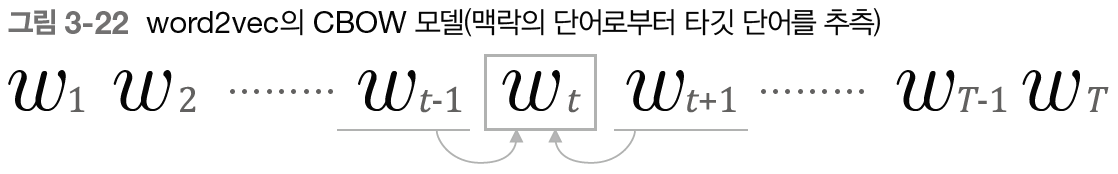

In [27]:
Image.open(os.path.join(img_path, 'fig 3-22.png'))

즉 맥락으로 $w_{t-1}$ 과 $w_{t+1}$ 이 주어졌을 때 타깃이 $w_{t}$ 가 될 확률은 다음과 같이 사후 확률을 사용해서 쓸 수 있다.

\begin{equation*}
    P(w_{t} | w_{t-1}, w_{t+1})
    \tag{3.1}
\end{equation*}

위 식을 사용하면 CBOW 모델의 손실 함수도 간결하게 표현할 수 있다.

앞서 1장의 교차 엔트로피 오차 $L = - \textstyle\sum_{k} t_k \log y_k$ 를 활용한다.

여기서 문제의 정답은 '$w_t$ 가 발생'이므로 $w_t$ 에 해당하는 원소만 1이고 나머지는 0이 된다. 이 점을 감안하면 다음 식이 유도된다.

\begin{equation*}
    L = - \log P(w_{t} | w_{t-1}, w_{t+1})
    \tag{3.2}
\end{equation*}

이를 $\textbf{음의 로그 가능도}^{\text{negative log likelihood}}$ 라고 하는데, 이를 말뭉치 전체로 확장하면 다음과 같이 쓸 수 있다.

\begin{equation*}
    L = - \cfrac{1}{T} \displaystyle\sum_{t=1}^{T} \log P(w_{t} | w_{t-1}, w_{t+1})
    \tag{3.3}
\end{equation*}

CBOW 모델의 학습이 하는 일은 이 손실 함수의 값을 가능한 한 작게 만드는 것이다.

그리고 이때의 가중치 매개변수가 우리가 얻고자 하는 단어의 분산 표현이 되는 것이다.

여기서는 윈도우 크기가 1인 경우만 다뤘으나, 다른 크기(또는 $m$ 등의 범용적인 크기)여도 수식으로 쉽게 나타낼 수 있다.

### 3.5.2 skip-gram 모델

word2vec은 2개의 모델을 제안한다.

하나는 CBOW 모델, 다른 하나는 skip-gram 모델이다.

skip-gram은 CBOW에서 다루는 맥락과 타깃을 역전시킨 모델이다.

다음 그림으로 쉽게 이해할 수 있다.

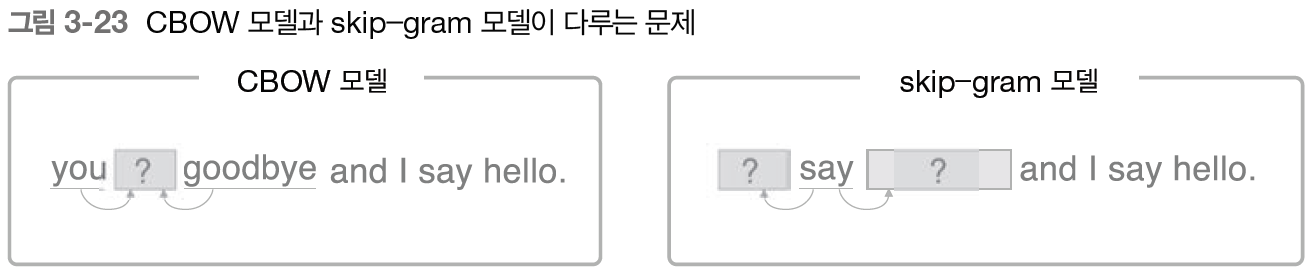

In [28]:
Image.open(os.path.join(img_path, 'fig 3-23.png'))

그림과 같이 CBOW 모델은 맥락이 여러 개 있고, 그 여러 맥락으로부터 중앙의 단어(타깃)를 추측한다.

한편, skip-gram 모델은 중앙의 단어(타깃)로부터 주변의 여러 단어(맥락)를 추측한다.

이러한 skip-gram 모델의 신경망 구성은 다음 그림과 같다.

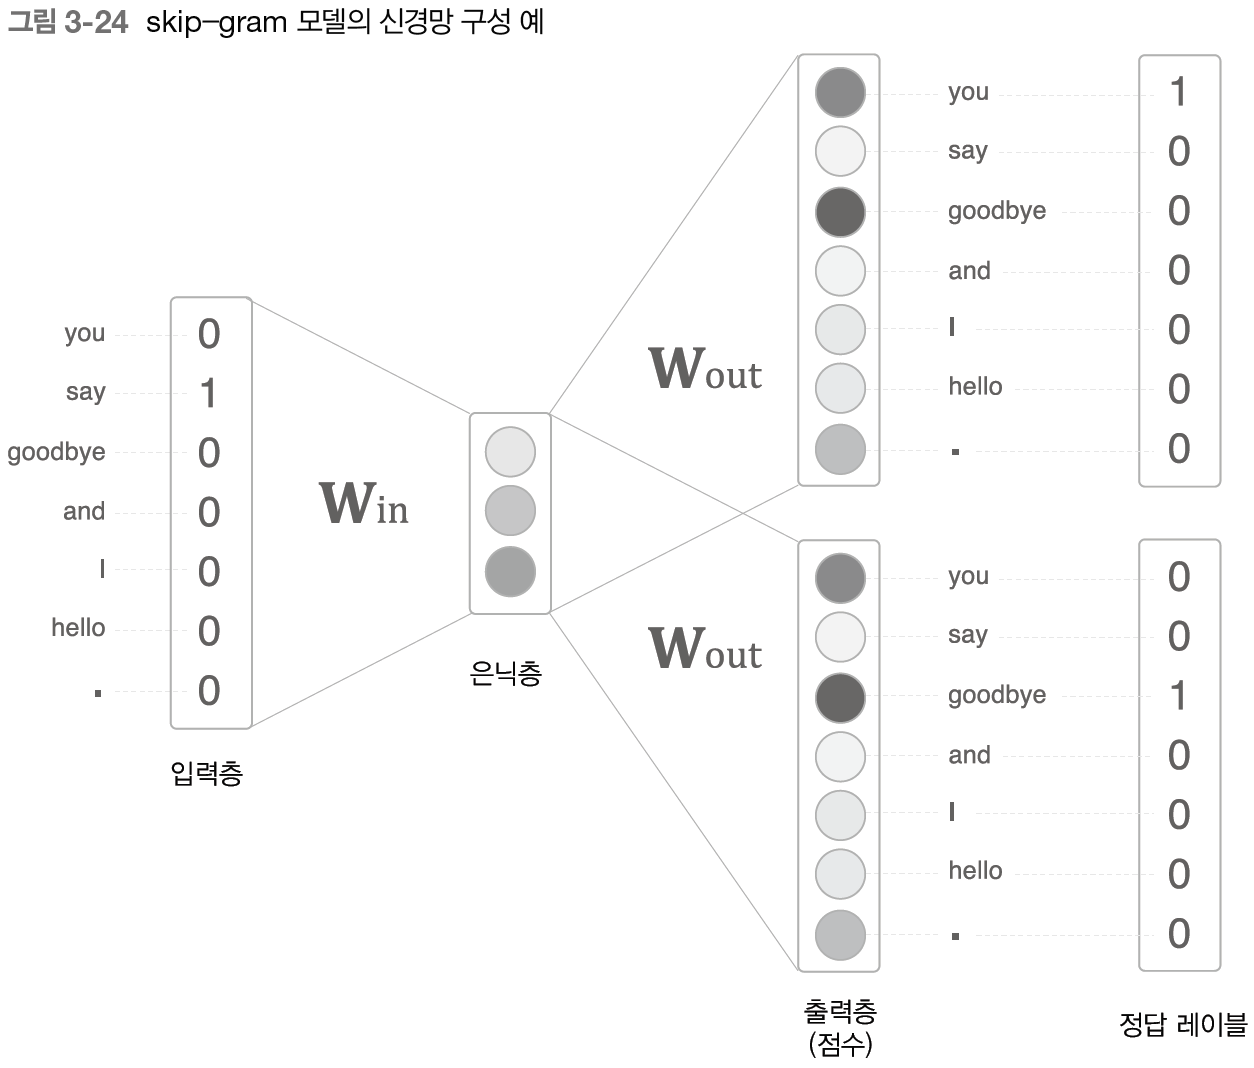

In [29]:
Image.open(os.path.join(img_path, 'fig 3-24.png'))

그림에서 보듯 skip-gram 모델의 입력층은 하나이다.

한편 출력층은 맥락의 수만큼 존재한다. 따라서 각 출력층에서는 (Softmax with Loss 계층 등을 이용하여) 개별적으로 손실을 구하고,

이 개별 손실들을 모두 더한 값을 최종 손실로 한다.

skip-gram 모델을 확률 표기로 나타내본다.

중앙 단어(타깃) $w_t$ 롭터 맥락인 $w_{t-1}, w_{t+1}$ 을 추측하는 경우를 생각해본다.

그러면 skip-gram은 다음을 모델링하는 과정을 거치게 된다.

\begin{equation*}
    P(w_{t-1}, w_{t+1} |w_{t} )
    \tag{3.4}
\end{equation*}

이때 skip-gram 모델에서는 맥락의 단어들 사이에 관련성이 없다고 가정하고 다음과 같이 분해한다(정확히는 조건부 독립 가정).

\begin{equation*}
    P(w_{t-1}, w_{t+1} |w_{t} ) = P(w_{t-1} |w_{t} )P(w_{t+1} |w_{t} )
    \tag{3.5}
\end{equation*}

그러면 이를 교차 엔트로피 오차에 적용하여 skip-gram 모델의 손실 함수를 유도할 수 있다.

\begin{align*}
    L &= - \log P(w_{t-1}, w_{t+1} |w_{t} ) \\
      &= - \log P(w_{t-1} |w_{t} )P(w_{t+1} |w_{t} ) \\
      &= - \left( \log P(w_{t-1} |w_{t} ) + \log P(w_{t+1} |w_{t} ) \right)
    \tag{3.6}
\end{align*}

이 유도 과정에서 보듯이, skip-gram 모델의 손실 함수는 맥락별 손실을 구한 다음 모두 더한다.

이를 말뭉치 전체로 확장하면 skip-gram 모델의 손실 함수는 다음과 같이 쓸 수 있다.

\begin{equation*}
    L = - \cfrac{1}{T} \displaystyle\sum_{t=1}^{T} \left( \log P(w_{t-1} |w_{t} ) + \log P(w_{t+1} |w_{t} ) \right)
    \tag{3.7}
\end{equation*}

CBOW 모델의 손실 함수와 달리, skip-gram 모델은 맥락의 수만큼 추측하기 때문에

그 손실 함수는 각 맥락에서 구한 손실의 총합이어야 한다.

반면, CBOW 모델은 타깃 하나의 손실을 구한다.

그럼 CBOW 모델과 skip-gram 모델 중 어느 것을 사용해야 할까?

이에 대한 답은 skip-gram 모델이라고 할 수 있다.

단어 분산 표현의 정밀도 면에서 skip-gram 모델의 결과가 더 좋은 경우가 많기 때문이다.

특히 말뭉치가 커질수록 저빈도 단어나 유추 문제의 성능 면에서 skip-gram 모델이 더 뛰어난 경향이 있다.

반면, 학습 속도 면에서는 CBOW 모델이 더 빠르다.

skip-gram 모델은 손실을 맥락의 수만큼 구해야 하기 때문에 계산 비용이 그만큼 커지기 때문이다.

skip-gram 코드는 chapter03/simple_skip_gram.py 참조

### 3.5.3 통계 기반 vs. 추론 기반

지금까지 통계 기반 기법과 추론 기반 기법(특히 word2vec)을 살펴보았다.

통계 기반 기법 : 말뭉치의 전체 통계로부터 1회 학습하여 단어의 분산 표현 획득

추론 기반 기법 : 말뭉치를 일부분씩 여러 번 보면서 학습(미니배치 학습).

$\textbf{어휘에 추가할 새 단어가 생겨서 단어의 분산 표현을 갱신해야 하는 상황}$
- 통계 기반 기법 : 계산을 처음부터 다시 해야 함.
- 추론 기반 기법 : 학습한 가중치를 초깃값으로 사용해서 다시 학습하면 됨.(기존의 학습 내용을 해치지 않으면서 단어의 분산 표현을 효율적으로 갱신)

$\textbf{단어의 분산 표현의 성격이나 정밀도}$
- 통계 기반 기법 : 단어의 유사성이 인코딩됨.
- 추론 기반 기법 : word2vec(특히 skip-gram 모델)은 단어의 유사성은 물론, 한층 복잡한 단어 사이의 패턴까지 파악하여 인코딩("king - man + woman = queen")

$\textbf{NOTE}$

"Don't count, Predict!" 로 시작하는 제목의 논문[24]이 2014년에 발표되었는데, 이 논문에 따르면 통계 기반 기법과 추론 기반 기법을 체계적으로 비교한 결과 추론 기반 기법이 항상 더 정확했다고 한다. 그러나 이후 다른 논문[25]에서는 단어의 유사성 관련 작업의 경우 정확성은 하이퍼파라미터에 크게 의존하며, 통계 기반과 추론 기반의 우열을 명확히 가릴 수 없다고 보고되었다.

$\textbf{추론 기반과 통계 기반의 연결성}$
- skip-gram과 네거티브 샘플링을 이용한 모델은 모두 말뭉치 전체의 동시발생 행렬(살짝 수정된)에 특수한 행렬 분해를 적용한 것과 같다[26].
- 특정 조건 하에서 추론 기반 기법과 통계 기반 기법은 '서로 연결되어 있다'

$\textbf{GloVe : 두 기법의 융합}$
- word2vec 이후 추론 기반과 통계 기반 기법을 융합한 GloVe[27]기법 등장
- GloVe의 기본 아이디어는 말뭉치 전체의 통계 정보를 손실 함수에 도입해서 미니배치 학습을 하는 것

## 3.6 정리

$\textbf{이번 장에서 배운 내용}$
- 추론 기반 기법은 추측하는 것이 목적이며, 그 부산물로 단어의 분산 표현을 얻을 수 있다.
- word2vec은 추론 기반 기법이며, 단순한 2층 신경망이다.
- word2vec은 skip-gram 모델과 CBOW 모델을 제공한다.
- CBOW 모델은 여러 단어(맥락)로부터 하나의 단어(타깃)를 추측한다.
- 반대로 skip-gram 모델은 하나의 단어(타깃)로부터 다수의 단어(맥락)를 추측한다.
- word2vec은 가중치를 다시 학습할 수 있으므로, 단어의 분산 표현 갱신이나 새로운 단어 추가를 효율적으로 수행할 수 있다.